In [1]:
import os
import glob
import grizli
import grizli.utils
from astropy.io import fits
from astropy import wcs   
from astropy.modeling import models
from skimage.morphology import label

# Pysynphot
pysyn_cdbs = os.getenv('PYSYN_CDBS')
if not pysyn_cdbs:
    pysyn_cdbs = os.path.join(os.getenv('GRIZLI'), 'cdbs')
    if not os.path.exists(pysyn_cdbs):
        os.mkdir(pysyn_cdbs)
    os.environ['PYSYN_CDBS'] = pysyn_cdbs
    
import pysynphot as S
bp = S.ObsBandpass('wfc3,ir,f140w')

/hpc/group/cosmology/zg64/miniconda3/envs/grizli39/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /hpc/group/cosmology/zg64/package-repo/grizli/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
from collections import OrderedDict
import grizli.multifit
import matplotlib as mpl    
import matplotlib.pyplot as plt    
import matplotlib.gridspec

import numpy as np

import astropy.io.fits as pyfits
import astropy.wcs as pywcs
from astropy.table import Table
import astropy.time

import drizzlepac
import photutils
import grizli.model
import grizli.fake_image

workdir = '/hpc/group/cosmology/zg64/package-repo/Roman_grism_sim'
if os.path.exists(workdir):
    os.chdir(workdir)

`import jwst` failed so JWST processing will not work!
Failed to `import dust_attenuation`
Install my fork with $ pip install git+https://github.com/gbrammer/dust_attenuation.git
Failed to `import dust_extinction`
Install my fork with $ pip install git+https://github.com/gbrammer/dust_extinction.git


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [3]:
# make fake grism image (just noise) first to get the header

NEXP =   10  # divided between 10 exposures
EXPTIME = 10000 # 10 ks ~ 4 HST orbits
ra, dec = 53.1592277508136, -27.782056346146


h, wcs =grizli.fake_image.wfc3ir_header(ra=ra, dec=dec, pa_aper=0)
h['TELESCOP'] = 'HST'
h['INSTRUME']= 'WFC3'  
grizli.fake_image.make_fake_image(h, output='roman_example_flt.fits', exptime=EXPTIME, nexp=NEXP)

 [astropy.io.fits.verify]


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fedd204ca00>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fedd1eb00d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fedd1eb0220>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fedd1eb0130>]

In [4]:
from astropy import wcs   
def get_counts(mag):
    counts = np.power(10, -0.4 * (mag - ZP))
    return counts

dirimage = 'roman_grism_test_dirimg.fits'
segfile = dirimage.replace('dirimg.fits', 'segmap.fits')
NPIX = 1024

# WFC3/IR F140W
ZP = 26.4524
mag1, mag2 = 19.5,19.5


# First create direct image and segfile
full_img = np.zeros((NPIX, NPIX))
# Create Gaussian function models
# stddev in pixels
gaussfunc1 = models.Gaussian2D(x_stddev=3, y_stddev=3)
gaussfunc2 = models.Gaussian2D(x_stddev=3, y_stddev=3)

# Put the two galaxies at predetermined locations
gaussfunc1.x_mean = 200
gaussfunc1.y_mean = 500
gaussfunc2.x_mean = 400
gaussfunc2.y_mean = 800

x, y = np.meshgrid(np.arange(NPIX), np.arange(NPIX))
full_img += gaussfunc1(x, y)
full_img += gaussfunc2(x, y)

# Get required coutns
counts1 = get_counts(mag1)
counts2 = get_counts(mag2)
all_counts = [counts1, counts2]

# Generate segmap
threshold = 0.3  # threshold to apply to the image
good = full_img > threshold  # these pixels belong to a source
segmap = label(good)  # now these pixels have unique SegIDs

nonzero_idx = np.where(segmap != 0)
segids = np.sort(np.unique(segmap[nonzero_idx]))

for i in range(len(segids)):
    segid = segids[i]
    segidx = np.where(segmap == segid)
    src_counts = np.sum(full_img[segidx])
    counts = all_counts[i]

    # scale
    scale_fac = counts / src_counts

    # Do not multiply the full img by the scale fac
    # or other sources will also be affected
    full_img[segidx] *= scale_fac

    print(segid, src_counts, counts, scale_fac)

# Save
# Create a header (pyLINEAR needs WCS)

dirimg_hdr = fits.getheader('roman_example_flt.fits')
hdr = dirimg_hdr
hdr['FILTER'] = 'f140w'
#hdr['EXPTIME'] = 140.25

del hdr['BACKGR']
del hdr['PHOTFLAM']
del hdr['PHOTPLAM']
del hdr['EXPTIME ']
del hdr['NEXP']

ihdul = fits.HDUList()


ext_sci = fits.ImageHDU(data=full_img, header=hdr, name='SCI')
ihdul.append(ext_sci)
'''
ext_err = fits.ImageHDU(data=np.sqrt(full_img), header=hdr, name='ERR')
ihdul.append(ext_err)
ext_dq = fits.ImageHDU(data=np.zeros(full_img.shape),
                        header=hdr, name='DQ')
ihdul.append(ext_dq)
'''
ihdul.writeto(dirimage, overwrite=True)

shdul = fits.HDUList()
ext1 = fits.ImageHDU(data=segmap, header=hdr, name='SCI')
shdul.append(ext1)
shdul.writeto(segfile, overwrite=True)

1 39.95278696327057 603.8930062135234 15.115165977499766
2 39.95278696327057 603.8930062135234 15.115165977499766


In [5]:
''' old code
h = grizli.model.GrismFLT(grism_file='roman_example_flt.fits', verbose=True, pad = (0,0),
                               ref_file='roman_grism_test_dirimg.fits', 
                               seg_file='roman_grism_test_segmap.fits')


h.compute_full_model(ids=[1,2], mags=[19.5,19.6], verbose=True)
'''

" old code\nh = grizli.model.GrismFLT(grism_file='roman_example_flt.fits', verbose=True, pad = (0,0),\n                               ref_file='roman_grism_test_dirimg.fits', \n                               seg_file='roman_grism_test_segmap.fits')\n\n\nh.compute_full_model(ids=[1,2], mags=[19.5,19.6], verbose=True)\n"

In [6]:
sim = grizli.multifit.GroupFLT(grism_files=['roman_example_flt.fits'], direct_files=[], 
                               ref_file='roman_grism_test_dirimg.fits', 
                               seg_file='roman_grism_test_segmap.fits', 
                               #catalog=cat,
                               cpu_count=1, pad=200)

Image cutout: x=slice(0, 1024, None), y=slice(0, 1024, None) [Out of range]
roman_example_flt.fits / blot reference roman_grism_test_dirimg.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 1024, None), y=slice(0, 1024, None) [Out of range]
roman_example_flt.fits / Pad ref HDU with 464 pixels
roman_example_flt.fits / blot segmentation roman_grism_test_segmap.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Files loaded - 0.95 sec.


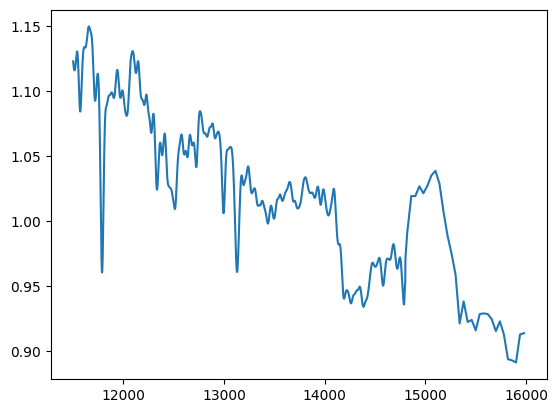

In [7]:
ref_3dhst = fits.open('udf_3dhst_cat.fits')
detection_bp = S.ObsBandpass('wfc3,ir,f140w')
templ = ref_3dhst['WAVE'].data*(1+ 1.0)
tempf = ref_3dhst['FLAMBDA'].data[16,:]
spec = S.ArraySpectrum(wave=templ, flux=tempf, waveunits='angstroms', fluxunits='flam')
spec = spec.renorm(1., 'flam', detection_bp)
mask, = np.where((spec.wave > 1.15e4) & (spec.wave < 1.6e4))
plt.plot(spec.wave[mask], spec.flux[mask])

In [8]:
for id in [1,2]:
    sim.compute_single_model(id, mag=19.5, size=-1, store=False, 
                            spectrum_1d=[spec.wave, spec.flux], get_beams=None, 
                            in_place=True)

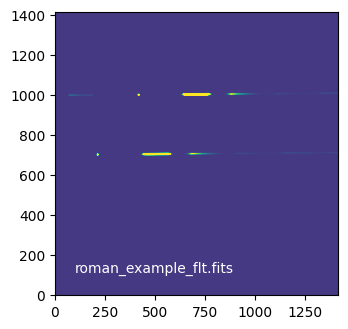

In [9]:
fig = plt.figure(figsize=[9,9*2./3])
for ix, i in enumerate([0]):
    ax = fig.add_subplot(2,3,ix+1)
    
    # show as if it were the rotated grism
    if (i % 2) > 0:
        ax.imshow(np.rot90(sim.FLTs[i].model,-1), vmin=-0.01, vmax=0.05, cmap='viridis', 
                  origin='lower')
    else:
        ax.imshow(sim.FLTs[i].model, vmin=-0.01, vmax=0.05, cmap='viridis', origin='lower')

    #ax.set_xticklabels([]); ax.set_yticklabels([])
    #ax.grid(color='w', alpha=0.8)
    ax.text(100,100,sim.FLTs[i].grism_file, color='w', size=10, ha='left', va='bottom')
fig.tight_layout(pad=0.1)

In [10]:
for flt in sim.FLTs:
    print('Update', flt.grism_file)
    orig_flt = fits.open(flt.grism_file, mode='update')
    orig_flt['SCI'].data = np.zeros(orig_flt['SCI'].data.shape)
    orig_flt['SCI'].data += flt.model[flt.pad[0]:-flt.pad[0], flt.pad[0]:-flt.pad[0]]
    orig_flt.flush()

Update roman_example_flt.fits


 [astropy.io.fits.verify]
